**Load & clean data**

In [8]:

import pandas as pd
import numpy as np
from math import radians, sin, cos, asin, sqrt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# -----------------------------
# Paths (adjust if needed)
# -----------------------------
bike_path = "/Users/sanjna/Documents/Virginia Tech/Courses/Urban Computing/Project/Code/Data/sample_dc_bikeshare/SAMPLE_DC_BIKE_2021_2023.csv"
ped_path  = "/Users/sanjna/Documents/Virginia Tech/Courses/Urban Computing/Project/Code/Data/dc_foot/DC-foot-traffic.csv"

# -----------------------------
# Load raw data
# -----------------------------
bike = pd.read_csv(bike_path)
ped = pd.read_csv(
    ped_path,
    encoding="utf-16",
    sep="\t",
    skip_blank_lines=True
)

# Clean column names
ped.columns = ped.columns.str.strip()

print("Bike shape:", bike.shape)
print("Ped shape:", ped.shape)
print(bike.head(3))
print(ped.head(3))

# -----------------------------
# Clean bikeshare: 2021–2023 DC only
# -----------------------------
# Parse start datetime
bike["start_datetime"] = pd.to_datetime(bike["started_at"], errors="coerce")

# Keep trips from 2021-01-01 to 2023-12-31
bike = bike[
    (bike["start_datetime"] >= "2021-01-01") &
    (bike["start_datetime"] <  "2024-01-01")
].copy()

# Drop rows missing station info / coords
bike = bike.dropna(
    subset=[
        "start_station_name", "end_station_name",
        "start_lat", "start_lng", "end_lat", "end_lng"
    ]
)

# Restrict to DC-ish bounding box using START coordinates
dc_mask = (
    (bike["start_lat"] >= 38.79) & (bike["start_lat"] <= 39.00) &
    (bike["start_lng"] >= -77.12) & (bike["start_lng"] <= -76.91)
)
bike = bike[dc_mask].copy()

print("\nBike (DC, 2021–2023) rows:", len(bike))

# Extract some temporal fields
bike["start_date"] = bike["start_datetime"].dt.date
bike["start_hour"] = bike["start_datetime"].dt.hour
bike["start_dow"]  = bike["start_datetime"].dt.dayofweek
bike["start_year"] = bike["start_datetime"].dt.year
bike["start_month"]= bike["start_datetime"].dt.month

# -----------------------------
# Clean pedestrian (2021–2023)
# -----------------------------
# Parse from 'Hour of Datetime', e.g. "October 6, 2017 at 11 AM"
ped["datetime"] = pd.to_datetime(
    ped["Hour of Datetime"],
    format="%B %d, %Y at %I %p",   # Month name, day, year, 'at', hour, AM/PM
    errors="coerce"
)

ped["Counts"] = pd.to_numeric(ped["Counts"], errors="coerce")

# Keep 2021–2023
ped = ped[
    (ped["datetime"] >= "2021-01-01") &
    (ped["datetime"] <  "2024-01-01")
].copy()

# Drop bad/missing counts
ped = ped.dropna(subset=["Counts"])
ped = ped[ped["Counts"] >= 0]

print("\nPed (2021–2023) rows:", len(ped))
print("\nUnique ped stations:", ped["Station"].nunique())
print(ped["Station"].value_counts().head(10))




/var/folders/mk/fk8xrhrd3931s55gl03bdrq80000gn/T/ipykernel_26795/2701585862.py:17: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  bike = pd.read_csv(bike_path)


Bike shape: (10486406, 14)
Ped shape: (404766, 3)
            ride_id  rideable_type           started_at             ended_at             start_station_name start_station_id  \
0  13A48BD20CC3DD85   classic_bike  2021-01-08 17:58:48  2021-01-08 18:25:23   Connecticut Ave & Yuma St NW          31318.0   
1  CA68C580B32EEE66  electric_bike  2021-01-08 22:05:51  2021-01-08 22:23:52                  8th & D St NW          31270.0   
2  5A925307814D5C2B   classic_bike  2021-01-21 17:20:31  2021-01-21 17:23:24  Wilson Blvd. & N. Vermont St.          31926.0   

                end_station_name end_station_id  start_lat  start_lng    end_lat    end_lng member_casual  \
0    Georgia Ave & Emerson St NW        31405.0  38.947156 -77.065115  38.949662 -77.027333        casual   
1                 14th & D St SE        31663.0  38.894804 -77.023091  38.884053 -76.986043        member   
2  George Mason Dr & Wilson Blvd        31036.0  38.879477 -77.114563  38.878870 -77.120700        member   



**Spatial Matching + Bike/Ped Hourly Aggregation**

In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, asin, sqrt

# ----------------------------
# Built-in coordinates (DC counters)
# ----------------------------
PED_COORDS = {
    "Wharf Classic - Maine Ave Cycle Track": (38.8811, -77.0210),
    "Rose Park Trail @ P Street NW": (38.9125, -77.0680),
    "Rock Creek Trail @ Shoreham Drive": (38.9320, -77.0550),
    "Piney Branch Trail": (38.9410, -77.0285),
    "Oxon Run Park West Bank": (38.8465, -76.9875),
    "Oxon Run Park East Bank": (38.8470, -76.9860),
    "Marvin Gaye Trail at 60th St NE": (38.8975, -76.9320),
    "Marvin Gaye Trail at 48th Pl NE": (38.9040, -76.9465),
    "Anacostia River Trail - Kenilworth Park": (38.9095, -76.9445),
    "Anacostia River Trail - Deane Ave": (38.8565, -76.9960),
    "Anacostia River Trail - Benning": (38.8950, -76.9620),
    "Anacostia River Trail - 11th St": (38.8640, -76.9920),
    "14th St NW": (38.9172, -77.0319),
    "11th St NW": (38.9100, -77.0280),
    "Columbia Rd NW": (38.9240, -77.0420)
}

print("Ped counters available:", len(PED_COORDS))

# ----------------------------------------
# Extract bikeshare station coordinates
# ----------------------------------------
bike_stations = bike.groupby(
    ["start_station_id", "start_station_name", "start_lat", "start_lng"]
).size().reset_index().rename(
    columns={"start_lat": "lat", "start_lng": "lon"}
)

bike_stations = bike_stations[["start_station_id", "start_station_name", "lat", "lon"]]
bike_stations["station"] = bike_stations["start_station_name"]

print("Unique bike stations:", len(bike_stations))

# ----------------------------------------
# Haversine distance
# ----------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*(sin(dlon/2)**2)
    return 2*R*asin(np.sqrt(a))

# ----------------------------------------
# Match each ped counter to all bike stations within 800 m
# ----------------------------------------
matches = []

for ped_name, (plat, plon) in PED_COORDS.items():
    for _, row in bike_stations.iterrows():
        dist = haversine(plat, plon, row.lat, row.lon)
        if dist <= 800:  # 800 meter threshold
            matches.append({
                "ped_station": ped_name,
                "bike_station": row.station,
                "distance_m": dist
            })

matches = pd.DataFrame(matches)
print("\nTotal matches:", len(matches))
print("Matched pedestrian counters:", matches["ped_station"].nunique())


# ----------------------------------------
# Aggregate bikeshare hourly
# ----------------------------------------
bike_hourly = bike.groupby(
    ["start_station_name", "start_date", "start_hour"]
).size().reset_index(name="bike_trips")

bike_hourly["datetime"] = pd.to_datetime(bike_hourly["start_date"]) + \
                          pd.to_timedelta(bike_hourly["start_hour"], unit="h")

print("\nHourly bike rows:", len(bike_hourly))

# ----------------------------------------
# Aggregate pedestrian hourly
# ----------------------------------------
ped_hourly = ped.groupby(
    ["Station", pd.Grouper(key="datetime", freq="H")]
).agg({"Counts": "sum"}).reset_index()

print("Hourly ped rows:", len(ped_hourly))

# ----------------------------------------
# Save outputs for RQ2/RQ3
# ----------------------------------------
station_matches = matches.copy()
print("\n✓ Spatial matching + hourly aggregation done.")


Ped counters available: 15
Unique bike stations: 1310695

Total matches: 385663
Matched pedestrian counters: 14

Hourly bike rows: 3798680
Hourly ped rows: 165453

✓ Spatial matching + hourly aggregation done.


/var/folders/mk/fk8xrhrd3931s55gl03bdrq80000gn/T/ipykernel_26795/880538868.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ["Station", pd.Grouper(key="datetime", freq="H")]


**RQ2 + RQ3 (2021–2023, DC)**

In [10]:
import pandas as pd
import numpy as np

# ---------------------------------------------------
# RQ2: Latent Demand (High Foot, Low Bikeshare)
# ---------------------------------------------------

rows = []

# Map: ped_station → list of matched bike stations
ped_to_bikes = (
    station_matches
    .groupby("ped_station")["bike_station"]
    .unique()
)

print("Ped counters with at least one matched bike station:", len(ped_to_bikes))

for ped_station, bike_stations in ped_to_bikes.items():
    # Pedestrian time series for that counter
    ped_ts = ped_hourly[ped_hourly["Station"] == ped_station].copy()
    
    if ped_ts.empty:
        continue
    
    # Bikeshare time series: sum of trips at all nearby stations (within 800m)
    bike_ts = (
        bike_hourly[bike_hourly["start_station_name"].isin(bike_stations)]
        .groupby("datetime", as_index=False)["bike_trips"]
        .sum()
    )
    
    if bike_ts.empty:
        continue
    
    # Align on datetime
    merged = ped_ts.merge(bike_ts, on="datetime", how="inner")
    
    # Skip if not enough overlapping hours
    if len(merged) < 50:   # you can tune this threshold
        continue
    
    rows.append({
        "ped_station": ped_station,
        "n_obs": len(merged),
        "mean_ped_hourly": merged["Counts"].mean(),
        "mean_bike_hourly": merged["bike_trips"].mean()
    })

rq2 = pd.DataFrame(rows)

if rq2.empty:
    print("No stations with enough overlapping data. Check thresholds or data ranges.")
else:
    print("\nBase RQ2 table (before percentiles):")
    print(rq2)

    # ---------------------------------------------------
    # Compute percentiles & latent demand score
    # ---------------------------------------------------
    rq2["ped_percentile"]  = rq2["mean_ped_hourly"].rank(pct=True)
    rq2["bike_percentile"] = rq2["mean_bike_hourly"].rank(pct=True)

    rq2["latent_demand"] = rq2["ped_percentile"] - rq2["bike_percentile"]

    # Flag RQ2 hotspots:
    # high foot (≥ 90th percentile) AND low bikeshare (≤ 30th percentile)
    rq2["is_RQ2_hotspot"] = (
        (rq2["ped_percentile"]  >= 0.90) &
        (rq2["bike_percentile"] <= 0.30)
    )

    # ---------------------------------------------------
    # RQ3: Accessibility Gaps (Busy but Poorly Served)
    # ---------------------------------------------------
    # Simple accessibility proxy = mean bikeshare activity near the counter
    rq2["accessibility_score"]      = rq2["mean_bike_hourly"]
    rq2["accessibility_percentile"] = rq2["accessibility_score"].rank(pct=True)

    # RQ3 gap:
    #  - pedestrian ≥ 75th percentile (busy)
    #  - accessibility ≤ 25th percentile (poorly served by bikes)
    rq2["is_RQ3_gap"] = (
        (rq2["ped_percentile"]           >= 0.75) &
        (rq2["accessibility_percentile"] <= 0.25)
    )

    # Sort by latent demand (highest first)
    rq2 = rq2.sort_values("latent_demand", ascending=False)

    # Save to CSV for use in your report
    rq2.to_csv("DC_RQ2_RQ3_2021_2023_results.csv", index=False)

    print("\n================ RQ2 / RQ3 SUMMARY (DC 2021–2023) ================")
    print(rq2[[
        "ped_station",
        "n_obs",
        "mean_ped_hourly",
        "mean_bike_hourly",
        "ped_percentile",
        "bike_percentile",
        "latent_demand",
        "is_RQ2_hotspot",
        "accessibility_score",
        "accessibility_percentile",
        "is_RQ3_gap"
    ]])

    # Show top 5 latent-demand locations
    print("\nTop 5 highest latent demand (foot >> bike):")
    print(
        rq2[["ped_station", "mean_ped_hourly", "mean_bike_hourly", "latent_demand", "is_RQ2_hotspot"]]
        .head(5)
        .to_string(index=False)
    )

    # Show any RQ3 gaps
    gaps = rq2[rq2["is_RQ3_gap"]]
    print("\nRQ3 gaps (busy but low bikeshare accessibility):")
    if gaps.empty:
        print("  None found under current thresholds.")
    else:
        print(
            gaps[["ped_station", "mean_ped_hourly", "mean_bike_hourly",
                  "ped_percentile", "accessibility_percentile", "is_RQ3_gap"]]
            .to_string(index=False)
        )


Ped counters with at least one matched bike station: 14

Base RQ2 table (before percentiles):
                              ped_station  n_obs  mean_ped_hourly  mean_bike_hourly
0                              11th St NW  18059         8.152722        114.197242
1                              14th St NW  18438         6.974889        116.134559
2         Anacostia River Trail - 11th St   1039       546.722810          6.305101
3         Anacostia River Trail - Benning   1912        34.346757          3.974895
4       Anacostia River Trail - Deane Ave   2033        31.851451          1.201672
5                          Columbia Rd NW  21314        11.902458         81.301023
6         Marvin Gaye Trail at 48th Pl NE    858         6.689977          1.317016
7         Marvin Gaye Trail at 60th St NE    491         7.148676          1.193483
8                 Oxon Run Park East Bank   2429         5.012351          3.977357
9                 Oxon Run Park West Bank   3076        13.537711 

**Latent Demand Bar Chart**

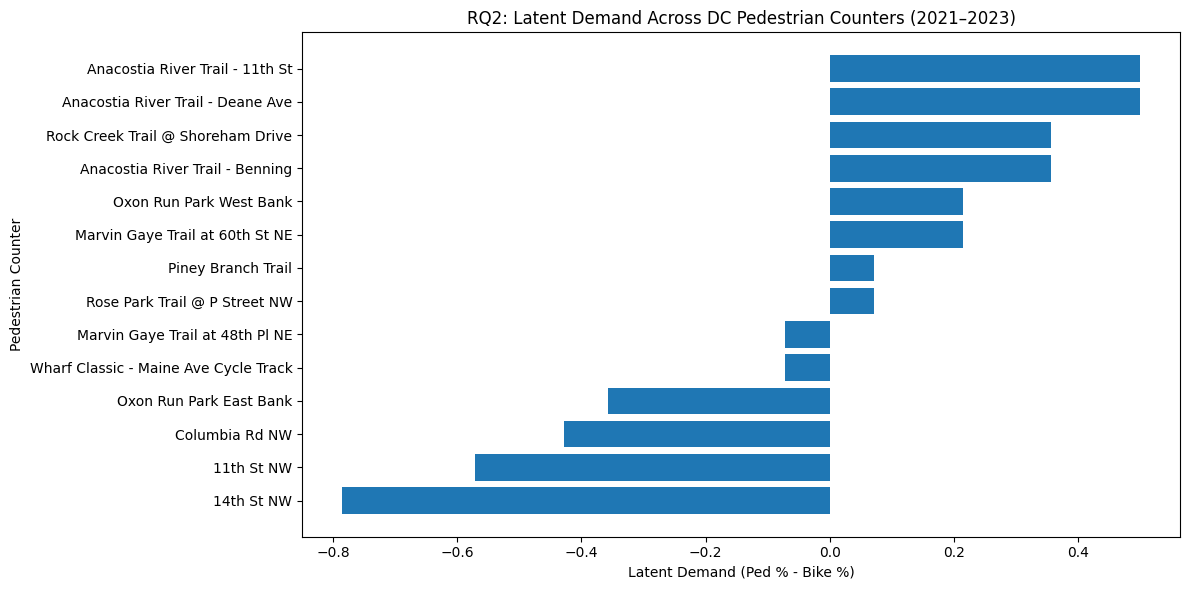

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

rq2_sorted = rq2.sort_values("latent_demand", ascending=False)

plt.barh(
    rq2_sorted["ped_station"],
    rq2_sorted["latent_demand"]
)

plt.xlabel("Latent Demand (Ped % - Bike %)")
plt.ylabel("Pedestrian Counter")
plt.title("RQ2: Latent Demand Across DC Pedestrian Counters (2021–2023)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


**RQ2 Scatter: Pedestrian vs Bikeshare Percentiles**

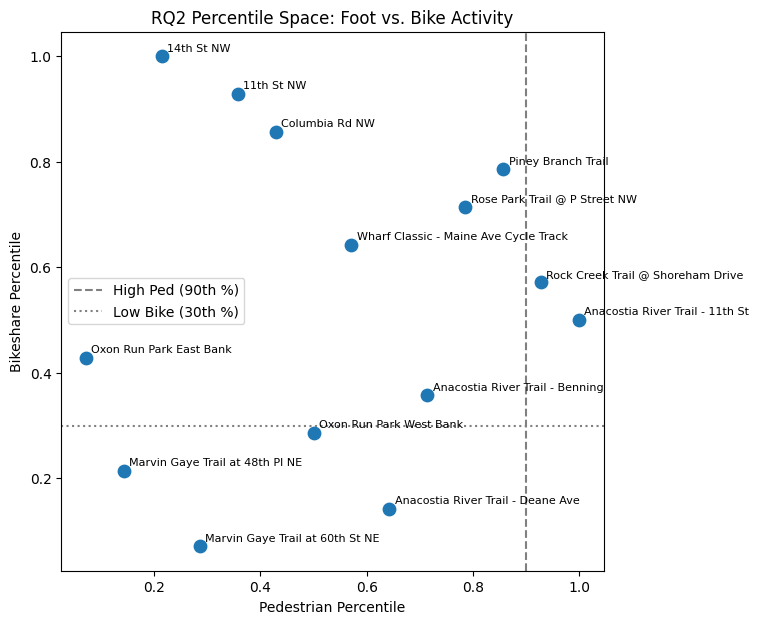

In [13]:
plt.figure(figsize=(7,7))

plt.scatter(
    rq2["ped_percentile"],
    rq2["bike_percentile"],
    s=80
)

for _, r in rq2.iterrows():
    plt.text(r["ped_percentile"]+0.01, r["bike_percentile"]+0.01, r["ped_station"], fontsize=8)

plt.xlabel("Pedestrian Percentile")
plt.ylabel("Bikeshare Percentile")
plt.title("RQ2 Percentile Space: Foot vs. Bike Activity")

# Add reference lines
plt.axvline(0.9, color='gray', linestyle='--', label="High Ped (90th %)")
plt.axhline(0.3, color='gray', linestyle=':',  label="Low Bike (30th %)")

plt.legend()
plt.show()


**RQ3 Accessibility Gap Plot**

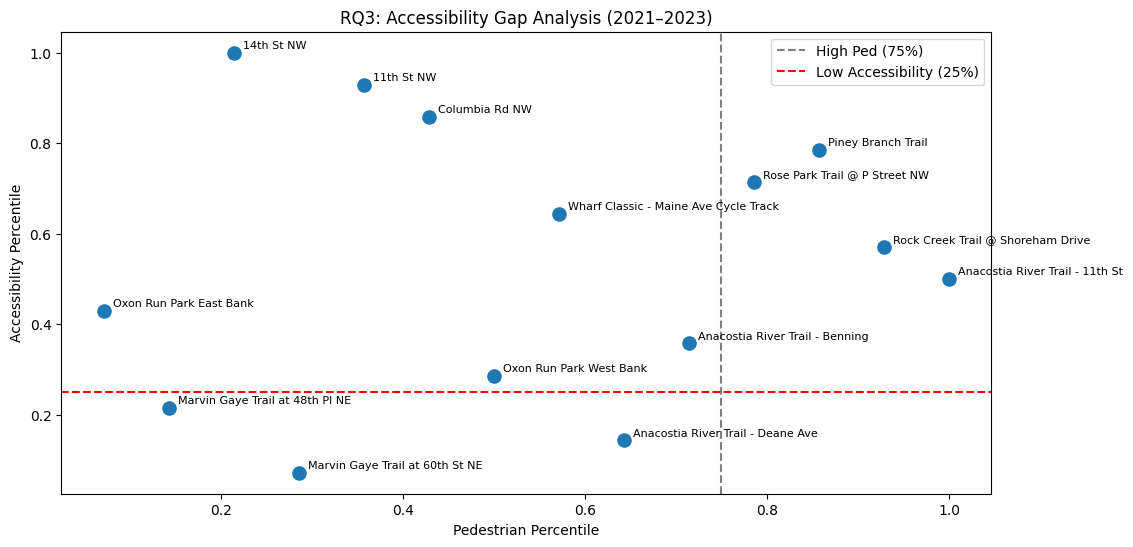

In [14]:
plt.figure(figsize=(12,6))

plt.scatter(
    rq2["ped_percentile"],
    rq2["accessibility_percentile"],
    s=90
)

for _, r in rq2.iterrows():
    plt.text(r["ped_percentile"]+0.01, r["accessibility_percentile"]+0.01, r["ped_station"], fontsize=8)

plt.axvline(0.75, linestyle='--', color='gray', label="High Ped (75%)")
plt.axhline(0.25, linestyle='--', color='red', label="Low Accessibility (25%)")

plt.xlabel("Pedestrian Percentile")
plt.ylabel("Accessibility Percentile")
plt.title("RQ3: Accessibility Gap Analysis (2021–2023)")
plt.legend()
plt.show()
